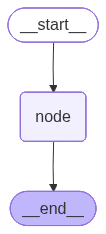

================================ Human Message =================================

Hi
================================== Ai Message ==================================

你好!


In [12]:
from IPython.display import Image, display
from dataclasses_json import config
from langchain_core.messages import AIMessage
from langchain_core.messages import AnyMessage
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph
from typing_extensions import TypedDict

# 第一个langgraph例子
# 节点间通讯的消息类型
class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("你好!")
    return {"messages": messages + [new_message], "extra_field": 10}

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

# 画出图形
display(Image(graph.get_graph().draw_mermaid_png()))

# 调用graph得到结果
result = graph.invoke({"messages": [HumanMessage("Hi")]})
for message in result["messages"]:
    message.pretty_print()

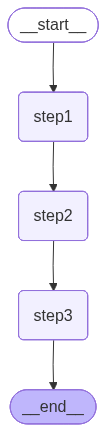

{'value1': 'a b', 'value2': 10}

In [11]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, StateGraph

class State(TypedDict):
    value1:str
    value2:str

def step1(state: State):
    return {"value1": "a"}

def step2(state: State):
    return {"value1": f"{state["value1"]} b"}

def step3(state: State):
    return {"value2": 10}

graph_builder = StateGraph(State)

# 串行图
# 添加节点
graph_builder.add_node(step1)
graph_builder.add_node(step2)
graph_builder.add_node(step3)

# 添加edge
graph_builder.add_edge(START, "step1")
graph_builder.add_edge("step1", "step2")
graph_builder.add_edge("step2", "step3")

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"value1": "c"})


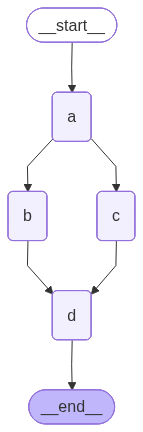

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

In [19]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 分支结构的图

# Annotated允许为类型提示添加额外的元数据，而不影响类型检查器对类型本身的理解
class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"aggregate": []}, {"congigurable": {"thread_id": "foo"}})


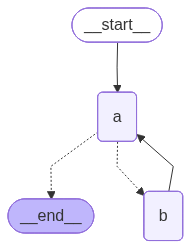

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

In [24]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

# 定义route
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END

builder.add_edge(START, "a")
# 定义条件边
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"aggregate": []})

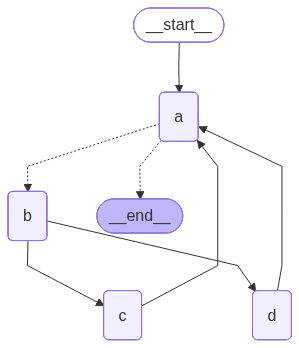

Node A sees []
Node B sees ['A']
Node C sees ['A', 'B']
Node D sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Node B sees ['A', 'B', 'C', 'D', 'A']
Node C sees ['A', 'B', 'C', 'D', 'A', 'B']
Node D sees ['A', 'B', 'C', 'D', 'A', 'B']
Node A sees ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


In [30]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}

# 节点
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)

def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

result = graph.invoke({"aggregate": []})

In [40]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_deepseek import ChatDeepSeek
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import END, StateGraph, START
import os
from dotenv import load_dotenv

load_dotenv()

model = ChatDeepSeek(
    model="deepseek-v3",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    api_base=os.environ.get("OPENAI_API_BASE")
)

model1 = ChatOpenAI(
    model="gpt-4-turbo",
    temperature=0,
    api_key=os.getenv("OPENAI_API_KEY"),
    base_url=os.getenv("OPENAI_API_BASE")
)

models = {
    "deepseek": model,
    "openai": model1
}

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

# 节点使用模型
def _call_model(state: AgentState, config: RunnableConfig):
    model_name = config["configurable"].get("model", "deepseek")
    model = models[model_name]
    response = model.invoke(state["messages"])
    return {"messages": [response]}

builder = StateGraph(AgentState)
builder.add_node("model", _call_model)

builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

graph.invoke({"messages": [HumanMessage(content="hi 你是谁？")]})

# 切换openai
config = {"configurable": {"model": "openai"}}
graph.invoke({"messages": [HumanMessage(content="hi 你是谁？")]}, config=config)


{'messages': [HumanMessage(content='hi 你是谁？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='你好！我是 ChatGPT，一个由 OpenAI 开发的人工智能助手。我可以帮助你解答问题、写作、翻译、学习新知识等。有什么我可以帮你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 12, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-CiiP2Vg0yEPNTOWHzl9zjQvPMTVLo', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--11fca2b3-5e34-40c4-a2a3-ec326ba0a57d-0', usage_metadata={'input_tokens': 12, 'output_tokens': 42, 'total_tokens': 54, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

{'generate_topics': {'subjects': ['动物']}}
{'generate_joke': {'jokes': ['为什么鸡要过马路？因为它要到对面去！']}}


In [19]:
#起名大师，输出格式为一个数组
from langchain_openai import OpenAI
from langchain_core.prompts import PromptTemplate
import os
from langchain_core.output_parsers import BaseOutputParser
from dotenv import load_dotenv

#自定义类
class CommaSeparatedListOutputParser(BaseOutputParser):
    """Parse the output of an LLM call to a comma-separated list."""

    def parse(self, text: str):
        """Parse the output of an LLM call."""
        if hasattr(text, 'content'):
            text = text.content
        t = text.strip().split(",")
        print(t)
        return t

load_dotenv()

llm = ChatOpenAI(
    model="gpt-3.5-turbo-instruct",
    temperature=0,
    api_key=os.getenv("OPENAI_API_KEY"), 
    base_url=os.getenv("OPENAI_API_BASE")
)
prompt = PromptTemplate.from_template("你是一个起名大师，请模仿示例起3个{county}名字，比如：男孩经常被叫做{boy},女孩经常被叫做{girl}")
message=prompt.format(county="中国广东特色", boy="狗剩", girl="翠花")
print(message)
strs = llm.invoke(message)
CommaSeparatedListOutputParser().parse(strs)

你是一个起名大师，请模仿示例起3个中国特色名字，比如：男孩经常被叫做狗剩,女孩经常被叫做翠花
['当然可以！以下是三个具有中国特色的名字：\n\n1. 男孩：小虎\n2. 女孩：梅花\n3. 男孩：阿强\n\n这些名字都带有亲切感和传统色彩，符合中国特色的命名习惯。希望你喜欢！']


['当然可以！以下是三个具有中国特色的名字：\n\n1. 男孩：小虎\n2. 女孩：梅花\n3. 男孩：阿强\n\n这些名字都带有亲切感和传统色彩，符合中国特色的命名习惯。希望你喜欢！']

In [21]:
from langchain_openai import ChatOpenAI  # 确保正确导入 ChatOpenAI
from langchain_core.prompts import PromptTemplate
import os
from dotenv import load_dotenv
from langchain_core.output_parsers import BaseOutputParser

# 自定义解析器
class CommaSeparatedListOutputParser(BaseOutputParser):
    def parse(self, text):
        if hasattr(text, 'content'):
            text = text.content
        return text.strip().split(",")

# 加载环境变量
load_dotenv()
# 初始化 LLM
llm = ChatOpenAI(
    model="gpt-3.5-turbo-instruct",
    temperature=0,
    api_key=os.getenv("OPENAI_API_KEY"), 
    base_url=os.getenv("OPENAI_API_BASE")
)
 
# 创建提示模板
prompt = PromptTemplate.from_template(
    "你是一个起名大师，请模仿示例起3个{county}名字，比如：男孩经常被叫做{boy},女孩经常被叫做{girl}"
)
 
# 生成具体输入
message = prompt.format(
    county="中国特色",
    boy="狗剩",
    girl="翠花"
)
 
# 调用 LLM 并解析结果
response = llm.invoke(message)
parsed_result = CommaSeparatedListOutputParser().parse(response)
 
print("原始响应内容:", response.content)
print("解析后结果:", parsed_result)

原始响应内容: 当然可以！以下是三个具有中国特色的名字：

1. 男孩：小虎
2. 女孩：梅花
3. 男孩：阿强

这些名字都带有一定的亲切感和传统色彩。希望你喜欢！
解析后结果: ['当然可以！以下是三个具有中国特色的名字：\n\n1. 男孩：小虎\n2. 女孩：梅花\n3. 男孩：阿强\n\n这些名字都带有一定的亲切感和传统色彩。希望你喜欢！']


In [3]:
from langchain_openai import ChatOpenAI
import os
import asyncio

llm = ChatOpenAI(
    model="gpt-4",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
)
question="langchain是什么？"

# invoke事件，同步调用LLM处理单个输入，返回完整响应。
# llm.invoke(question)

# stream事件，同步流式返回LLM的响应块（tokens），支持实时输出。
# for chunk in llm.stream(question):
#     print(chunk.content + "|")

# batch 事件，批量处理多个输入，返回结果列表。
# llm.batch(["langchain作者是谁？", "langchain竞品有哪些？"])

# 异步事件流 astream_events。异步流式返回LLM执行过程中的事件（如开始、结束、中间步骤）。
async for event in llm.astream_events("介绍langchain", version="v2"):
    print(f"event={event['event']} | name={event['name']} | data={event['data']}")



event=on_chat_model_start | name=ChatOpenAI | data={'input': '介绍langchain'}
event=on_chat_model_stream | name=ChatOpenAI | data={'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--5547a2d8-aace-4f4a-a1f1-39bfabaede77', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
event=on_chat_model_stream | name=ChatOpenAI | data={'chunk': AIMessageChunk(content='Lang', additional_kwargs={}, response_metadata={}, id='run--5547a2d8-aace-4f4a-a1f1-39bfabaede77', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
event=on_chat_model_stream | name=ChatOpenAI | data={'chunk': AIMessageChunk(content='Chain', additional_kwargs={}, response_metadata={}, id='run--5547a2d8-aace-4f4a-a1f1-39bfabaede77', usag

In [8]:
from typing import Optional
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv

# 加载环境变量
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4-turbo",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
    )

class Joke(BaseModel):
    """Joke to tell user."""
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    rating: Optional[int] = Field(
        default=None, description="How funny the joke is, from 1 to 10"
    )
structured_llm = llm.with_structured_output(Joke, method="function_calling")
structured_llm.invoke("给我讲一个关于程序员的笑话")

Joke(setup='Why do programmers prefer dark mode?', punchline='Because light attracts bugs!', rating=None)

In [12]:
from typing_extensions import Annotated, TypedDict
from langchain_openai import ChatOpenAI
from typing import Optional, Union
import os
from dotenv import load_dotenv

# 加载环境变量
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4-turbo",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
    )

class Joke(TypedDict):
    """Joke to tell user."""
    setup: Annotated[str, ..., "the setup of the joke"]
    punchline: Annotated[str, ..., "The punchline of the joke"]
    rating: Annotated[Optional[int], None, "How funny the joke is, from 1 to 10"]

structured_llm = llm.with_structured_output(Joke, method="function_calling")
for chunk in structured_llm.stream("给我讲一个关于程序员的笑话"):
    print(chunk)




{}
{'setup': ''}
{'setup': '为'}
{'setup': '为什'}
{'setup': '为什么'}
{'setup': '为什么程序'}
{'setup': '为什么程序员'}
{'setup': '为什么程序员喜'}
{'setup': '为什么程序员喜欢'}
{'setup': '为什么程序员喜欢黑'}
{'setup': '为什么程序员喜欢黑暗'}
{'setup': '为什么程序员喜欢黑暗？'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': ''}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因为'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因为光'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因为光会'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因为光会产'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因为光会产生'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因为光会产生bug'}
{'setup': '为什么程序员喜欢黑暗？', 'punchline': '因为光会产生bug！'}


In [3]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_anthropic import ChatAnthropic
import time
import os
from dotenv import load_dotenv

# 加载环境变量
load_dotenv()

rate_limiter = InMemoryRateLimiter(
    requests_per_second=1,  # 每1秒请求一次
    check_every_n_seconds=0.1,  # 每100毫秒检查一次是否允许
    max_bucket_size=10,  # 控制最大突发大小
)
#定义模型调用
from langchain_anthropic import ChatAnthropic
model = ChatAnthropic(
    model="claude-3-5-sonnet-20241022",
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
rate_limiter=rate_limiter #请求速率限制
)
#使用计时器来计算
# 每次请求的时间间隔
for _ in range(5):
    tic = time.time()
    model.invoke("hello")
    toc = time.time()
    print(toc - tic)

NotFoundError: Error code: 404 - {'error': {'message': 'Not found', 'type': 'invalid_request_error'}}

In [1]:
from typing_extensions import Annotated, TypedDict
from langchain_openai import ChatOpenAI
from typing import Optional, Union
import os
from dotenv import load_dotenv

# 加载环境变量
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4-turbo",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
    )

class Joke(TypedDict):
    """Joke to tell user."""
    setup: Annotated[str, ..., "the setup of the joke"]
    punchline: Annotated[str, ..., "The punchline of the joke"]
    rating: Annotated[Optional[int], None, "How funny the joke is, from 1 to 10"]

structured_llm = llm.with_structured_output(Joke, method="function_calling")
for chunk in structured_llm.stream("给我讲一个关于设计师的笑话"):
    print(chunk)

{}
{'setup': ''}
{'setup': 'Why'}
{'setup': 'Why did'}
{'setup': 'Why did the'}
{'setup': 'Why did the designer'}
{'setup': 'Why did the designer bring'}
{'setup': 'Why did the designer bring a'}
{'setup': 'Why did the designer bring a pencil'}
{'setup': 'Why did the designer bring a pencil to'}
{'setup': 'Why did the designer bring a pencil to bed'}
{'setup': 'Why did the designer bring a pencil to bed?'}
{'setup': 'Why did the designer bring a pencil to bed?', 'punchline': ''}
{'setup': 'Why did the designer bring a pencil to bed?', 'punchline': 'To'}
{'setup': 'Why did the designer bring a pencil to bed?', 'punchline': 'To draw'}
{'setup': 'Why did the designer bring a pencil to bed?', 'punchline': 'To draw the'}
{'setup': 'Why did the designer bring a pencil to bed?', 'punchline': 'To draw the curtains'}
{'setup': 'Why did the designer bring a pencil to bed?', 'punchline': 'To draw the curtains!'}


In [ ]:
%%sql


In [30]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
import os

class add(BaseModel):
    """Add two integers."""
    a: int = Field(..., description="The first integer")
    b: int = Field(..., description="The second integer")

class multiply(BaseModel):
    """Multiply two integers."""
    a: int = Field(..., description="The first integer")
    b: int = Field(..., description="The second integer")

llm = ChatOpenAI(
    model="gpt-4",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
)
tools = [add, multiply]
# 绑定工具
llm_with_tools = llm.bind_tools(tools);
query="3乘以12是多少？"
# 大模型处理“3乘以12”的时候调用了multiply类
llm_with_tools.invoke(query).tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 12},
  'id': 'call_kGIWv7XijyYEu67r61AoJW1Y',
  'type': 'tool_call'}]